# Clustering of genomic data

The aim of the analysis is to find some relevant data patterns through the application of clustering techniques on the dataset stored in data.txt. 

As shown in data.ipynb and data_processing.ipynb, the dataset consists of both genomic and clinical data;
custering is applied on genomic features, while some clinical features are considered as true labels and the outcome of the cluster analysis is compared with the clinical classification.

At the current state of the art, no evident correspondance between genomic data and clinical outcomes has been found; for this reason, supervised classification is not considered, since the training of data may be biased by false correspondance between features and classifications.

The failure of the following methods may be therefore due to both bad algorithm performances and real lack of correlation between genomic and clinical features.

#### Contents:
1. [Sample selection](#1)<br>
2. [Label exploration](#2)<br>
3. [Cluster analysis](#3)<br>
    3.1 [Clustering metrics](#3.1)<br>
    3.2 [Clustering on non-reduced dimensional dataset](#3.2)<br>
    3.3 [Clustering after dimensionality reduction](#3.3)<br>
    3.4 [Conclusions](#3.4)<br>

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pylab as plt
import warnings

## 1. Sample selection<a class="anchor" id="1"></a>

After importing the dataset as pandas dataframe, select only patients with all genomic features (presence of gene mutations and copy number aberrations, gene expressions and methylation values).

In [2]:
warnings.filterwarnings('ignore')

data_complete = pd.read_csv('data/data_processed.txt', sep='\t')
print('Total number of patients: ', len(data_complete))

data = data_complete.query("mut==True and cna==True and rna==True and meth==True").copy()
print('Number of patients with all genomic features: ', len(data))

data

Total number of patients:  2454
Number of patients with all genomic features:  1253


,mut_AKT1,mut_ARID1A,mut_ARID1B,mut_BAP1,mut_BRCA1,mut_BRCA2,mut_BRIP1,mut_CASP8,mut_CDH1,mut_CDKN1B,...,HER2_STATUS,PR_STATUS,COHORT,ER_IHC,HER2_SNP6,INTCLUST,CLAUDIN_SUBTYPE,THREEGENE,HISTOLOGICAL_SUBTYPE,PATIENT_ID
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Negative,Positive,1.0,Positve,NEUTRAL,9,LumB,NaN,Mixed,MB-0006
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Negative,Negative,1.0,Positve,GAIN,9,LumB,ER+/HER2- High Prolif,Ductal/NST,MB-0028
11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,Negative,Negative,1.0,Negative,LOSS,3,Her2,ER+/HER2- High Prolif,Lobular,MB-0035
15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Positive,Positive,1.0,Positve,GAIN,5,LumA,NaN,Ductal/NST,MB-0046
19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Negative,Positive,1.0,Positve,GAIN,10,LumB,NaN,Ductal/NST,MB-0054
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1974,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Negative,Negative,4.0,Positve,NEUTRAL,8,LumB,ER+/HER2- High Prolif,Ductal/NST,MB-7288
1975,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Negative,Positive,4.0,Positve,GAIN,4ER+,Normal,ER+/HER2- Low Prolif,Ductal/NST,MB-7289
1976,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Positive,Negative,4.0,Positve,GAIN,1,claudin-low,HER2+,Ductal/NST,MB-7291
1978,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Negative,Positive,4.0,Positve,NEUTRAL,3,LumA,ER+/HER2- Low Prolif,Ductal/NST,MB-7293


Name columns depending on the feature type.

In [3]:
cols_mut = data.columns[:28].tolist()
cols_cna = data.columns[28:154].tolist()
cols_rna = data.columns[154:216].tolist()
cols_meth = data.columns[216:-17].tolist()

## 2. Label exploration<a class="anchor" id="2"></a>

Count number of identical values of clinical features and verify presence of missing values. The following clinical data have been chosen as possible true classifications because they are related to molecular characteristics of the tumor and less affected by environmental and time-related factors.

In [4]:
cols_clin = data.columns[-13:]
for i in cols_clin[1:-1]:
    print(data[i].value_counts())
    print('Number of NaN: ',data[i].isna().sum(),'\n')

GRADE
3.0    611
2.0    488
1.0    107
Name: count, dtype: int64
Number of NaN:  47 

ER_STATUS
Positive    955
Negative    298
Name: count, dtype: int64
Number of NaN:  0 

HER2_STATUS
Negative    1094
Positive     159
Name: count, dtype: int64
Number of NaN:  0 

PR_STATUS
Positive    653
Negative    600
Name: count, dtype: int64
Number of NaN:  0 

COHORT
3.0    451
1.0    316
2.0    205
4.0    147
5.0    134
Name: count, dtype: int64
Number of NaN:  0 

ER_IHC
Positve     942
Negative    290
Name: count, dtype: int64
Number of NaN:  21 

HER2_SNP6
NEUTRAL    912
GAIN       270
LOSS        70
UNDEF        1
Name: count, dtype: int64
Number of NaN:  0 

INTCLUST
8       206
3       192
10      153
4ER+    137
7       125
5       122
9        94
1        81
6        55
2        45
4ER-     43
Name: count, dtype: int64
Number of NaN:  0 

CLAUDIN_SUBTYPE
LumA           458
LumB           279
Her2           163
Basal          140
claudin-low    118
Normal          90
NC               5


In [5]:
clinical_class_name = ['ER_STATUS','HER2_STATUS','PR_STATUS','ER_IHC','HER2_SNP6','GRADE','COHORT','THREEGENE','CLAUDIN_SUBTYPE','INTCLUST']
clinical_class_number = [2,2,2,2,3,3,5,4,6,11]

In [6]:
X = data[cols_mut+cols_cna+cols_rna+cols_meth].copy()
Y = data[data.columns[-12:-1]].copy()

## 3. Cluster analysis <a class="anchor" id="3"></a>

### 3.1 Clustering metrics <a class="anchor" id="3.1"></a>

In order to compare the outcome of the clustering methods and the clinical classification considered as true labels, three metrics are used:

**Fowlkes Mallows Score** is a pair counting based measure; defined as the geometric mean of the precision and the recall.

**Adjusted Rand Score** is a pair counting based measure, defined as the number of agreement pairs divided by the total number of pairs; it is permutation invariant and with chance normalization.

**Adjusted Mutual Information** is an information theoretic measure; it is based on fundamental concept of information theory and, in particular, on the concept of entropy; it is permutation invariant and with chance normalization.


In [7]:
from sklearn.metrics import fowlkes_mallows_score as fms
from sklearn.metrics import adjusted_rand_score as ars
from sklearn.metrics import adjusted_mutual_info_score as ami

### 3.2 Clustering on non-reduced dimensional dataset <a class="anchor" id="3.2"></a>

In this section two clustering methods are directly applied on the dataset, without any preprocessing. Since the dataset consists of mixed type features (genetic mutation and copy number alteration data are binary, while rna expression and methylation data are real number between zero and one), two methods that automatically recognize the two different feature typologies are considered.

Firstly, **Agglomerative Clustering** is considered. Since it is a hierarchical method that builds clusters according to a bottom up approach, it isn't able to automatically determine the number of clusters but it requires this parameter as input.
It is run with **Gower distance**, a measure that uses the concept of Manhattan distance for continuous variables and Dice distance for measuring similarity between binary variables.

Secondly, **k-Prototypes** algorithm is used, since it integrates k-Means for numeric data and k-Modes for categorical data.
**k-Means** groups data points together based on their similarity in distance to the centroid of their respective clusters, while **k-Modes** calculates the number of mismatches between categorical values.

For each method, Adjusted Mutual Information, Adjusted Rand Index and Fowlkes Mallows Score are computed for any possible classification of the dataset represented by clinical features.

#### Agglomerative Clustering with Gower distance

In [8]:
import gower
from sklearn.cluster import AgglomerativeClustering

In [9]:
dist_matrix = gower.gower_matrix(X)

for i in np.arange(len(clinical_class_name)):
    if (i==0) or (clinical_class_number[i] != clinical_class_number[i-1]):
        ac = AgglomerativeClustering(n_clusters=clinical_class_number[i], metric = "precomputed", linkage='complete').fit(dist_matrix)
    
    # delete rows with missing labels
    name = clinical_class_name[i]
    c = Y[name]
    df = pd.DataFrame([c,ac.labels_])
    df = df.T
    df.columns = [0,1]
    df = df.dropna()
    
    print(name)
    print('Number of clusters: ', len(np.unique(ac.labels_)))
    print('Adjusted Mutual Information: ', ami(df[0],df[1]))
    print('Adjusted Rand Index: ', ars(df[0],df[1]))
    print('Fowlkes Mallows Score: ', fms(df[0],df[1]),'\n')

ER_STATUS
Number of clusters:  2
Adjusted Mutual Information:  -0.00042170594984953396
Adjusted Rand Index:  0.015469884217736353
Fowlkes Mallows Score:  0.7394327977206036 

HER2_STATUS
Number of clusters:  2
Adjusted Mutual Information:  0.0005292165840629978
Adjusted Rand Index:  0.030819750514930556
Fowlkes Mallows Score:  0.8149840018467118 

PR_STATUS
Number of clusters:  2
Adjusted Mutual Information:  -0.0009620112766338206
Adjusted Rand Index:  0.0004632030483713186
Fowlkes Mallows Score:  0.6466396758340441 

ER_IHC
Number of clusters:  2
Adjusted Mutual Information:  -0.0014267346778472092
Adjusted Rand Index:  -0.0009920590869510247
Fowlkes Mallows Score:  0.7386002430739993 

HER2_SNP6
Number of clusters:  3
Adjusted Mutual Information:  0.000737087314294286
Adjusted Rand Index:  -0.00575679671474105
Fowlkes Mallows Score:  0.6648825700722323 

GRADE
Number of clusters:  3
Adjusted Mutual Information:  -0.003108188589070628
Adjusted Rand Index:  0.005375874679791025
Fowlke

#### K-Prototypes

In [10]:
from kmodes.kprototypes import KPrototypes

In [11]:
for i in np.arange(len(clinical_class_name)):
    if (i==0) or (clinical_class_number[i] != clinical_class_number[i-1]):
        clust = KPrototypes(n_clusters=clinical_class_number[i]).fit_predict(X, categorical=np.arange(len(cols_mut+cols_cna)).tolist())
    
    # delete rows with missing labels
    name = clinical_class_name[i]
    c = Y[name]
    df = pd.DataFrame([c,clust])
    df = df.T
    df.columns = [0,1]
    df = df.dropna()
    
    print(name)
    print('Number of clusters: ', len(np.unique(clust)))
    print('Adjusted Mutual Information: ', ami(df[0],df[1]))
    print('Adjusted Rand Index: ', ars(df[0],df[1]))
    print('Fowlkes Mallows Score: ', fms(df[0],df[1]),'\n')

ER_STATUS
Number of clusters:  2
Adjusted Mutual Information:  0.001551216718283032
Adjusted Rand Index:  0.022731932311856103
Fowlkes Mallows Score:  0.6347794926704006 

HER2_STATUS
Number of clusters:  2
Adjusted Mutual Information:  0.0031860687431207934
Adjusted Rand Index:  0.03173106065617597
Fowlkes Mallows Score:  0.6993274516909412 

PR_STATUS
Number of clusters:  2
Adjusted Mutual Information:  0.0025536344425451736
Adjusted Rand Index:  0.005698004674946236
Fowlkes Mallows Score:  0.5532547826809279 

ER_IHC
Number of clusters:  2
Adjusted Mutual Information:  -0.0005850129244698253
Adjusted Rand Index:  0.008900904815469308
Fowlkes Mallows Score:  0.631560232402771 

HER2_SNP6
Number of clusters:  3
Adjusted Mutual Information:  -0.0004653853975626404
Adjusted Rand Index:  -0.009886097936520434
Fowlkes Mallows Score:  0.4990094606459468 

GRADE
Number of clusters:  3
Adjusted Mutual Information:  -0.0013343361075696357
Adjusted Rand Index:  -0.00187981863096492
Fowlkes Mal

Both methods provide very bad results for any possible considered classification. This is possibly due to the large number of features of the dataset. In fact, even in presence of real correspondance between genomic data and clinical classification, it would be very difficult to find good results with such high number of features, if compared with the number of patients.
In order to overcome the problem of curse of dimensionality, dimensionality reduction is applied before clustering in the next section.

### 3.3 Clustering after dimensionality reduction  <a class="anchor" id="3.3"></a>

Since the dataset consists of 270 genomic features (cols_mut, cols_cna, cols_rna, cols_meth) and the number of patients (rows) is 1253, it is convenient to apply dimensionality reduction before clustering analysis. 

Two methods are used to perform dimensionality reduction: **Factor Analysis of Mixed Data** (FAMD) and **Autoencoder** (AE).

Cluster analysis is then applied on the lower-dimensional latent space using **k-Means** clustering and **Agglomerative Clustering**.

In [12]:
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

#### Factor Analysis of Mixed Data

In [13]:
from prince import FAMD

FAMD applies two different dimensionality reduction methods for categorical and continuous variables (respectively MCA and PCA). In order to make it automatically recognize the two different feature typologies, the type of the binary features is changed from float to str.

The plot shows the cumulative variance percentage in function of the number of dimensions. It is used in order to choose the lower number of components that doesn't loose too much information. In this case the threshold is set to 90% of variance. 

Number of components with 90% of cumulative variance percentage:  89


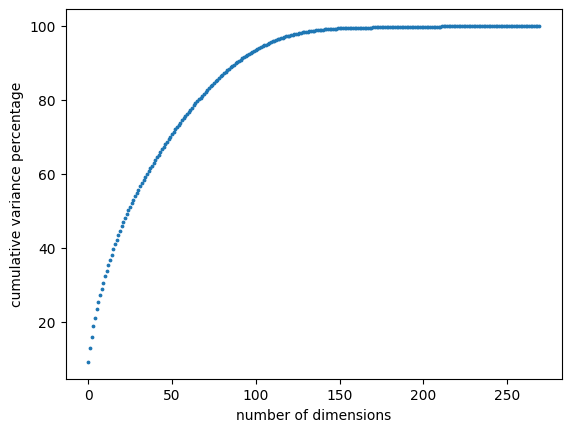

In [14]:
x = X.copy()
# change binary feature type
x[cols_mut+cols_cna] = x[cols_mut+cols_cna].astype(str)

famd = FAMD(n_components=len(x.columns)).fit(x)

plt.scatter(np.arange(len(x.columns)),famd.cumulative_percentage_of_variance_,s=3)
plt.xlabel('number of dimensions')
plt.ylabel('cumulative variance percentage')

n_comp = np.where(famd.cumulative_percentage_of_variance_>90)[0][0]
print('Number of components with 90% of cumulative variance percentage: ', n_comp)

Apply dimensionality reduction method with 89 components.

In [15]:
famd = FAMD(n_components=n_comp).fit_transform(x)

#### K-Means clustering after FAMD

K-Means clustering is applied to the outcome of FAMD and Adjusted Mutual Information, Adjusted Rand Index and Fowlkes Mallows Score are computed for any possible classification of the dataset represented by clinical features.

In [16]:
for i in np.arange(len(clinical_class_name)):
    if (i==0) or (clinical_class_number[i] != clinical_class_number[i-1]):
        clust = KMeans(n_clusters=clinical_class_number[i],random_state=0).fit_predict(np.array(famd))

    # delete rows with missing labels
    name = clinical_class_name[i]
    c = Y[name]
    df = pd.DataFrame([c,clust])
    df = df.T
    df.columns = [0,1]
    df = df.dropna()
    
    print(name)
    print('Number of clusters: ', len(np.unique(clust)))
    print('Adjusted Mutual Information: ', ami(df[0],df[1]))
    print('Adjusted Rand Index: ', ars(df[0],df[1]))
    print('Fowlkes Mallows Score: ', fms(df[0],df[1]),'\n')

ER_STATUS
Number of clusters:  2
Adjusted Mutual Information:  0.0005483049717228531
Adjusted Rand Index:  0.014138239464604064
Fowlkes Mallows Score:  0.6108753956956766 

HER2_STATUS
Number of clusters:  2
Adjusted Mutual Information:  0.0009972227547715012
Adjusted Rand Index:  0.017434398747468872
Fowlkes Mallows Score:  0.6721337630873172 

PR_STATUS
Number of clusters:  2
Adjusted Mutual Information:  0.0033127109581169325
Adjusted Rand Index:  0.006683102098028693
Fowlkes Mallows Score:  0.5353346298510355 

ER_IHC
Number of clusters:  2
Adjusted Mutual Information:  -0.0008204292826106307
Adjusted Rand Index:  0.004349757559288575
Fowlkes Mallows Score:  0.6091019069917375 

HER2_SNP6
Number of clusters:  3
Adjusted Mutual Information:  -0.0026620717452106217
Adjusted Rand Index:  -0.004930501312253715
Fowlkes Mallows Score:  0.48151758160100877 

GRADE
Number of clusters:  3
Adjusted Mutual Information:  -0.0003432033281125506
Adjusted Rand Index:  0.00036582741843386573
Fowlk

#### Agglomerative Clustering after FAMD

Agglomerative clustering is applied to the outcome of FAMD and Adjusted Mutual Information, Adjusted Rand Index and Fowlkes Mallows Score are computed for any possible classification of the dataset represented by clinical features.

In [17]:
for i in np.arange(len(clinical_class_name)):
    if (i==0) or (clinical_class_number[i] != clinical_class_number[i-1]):
        clust = AgglomerativeClustering(n_clusters=clinical_class_number[i]).fit_predict(np.array(famd))

    name = clinical_class_name[i]
    c = Y[name]
    df = pd.DataFrame([c,clust])
    df = df.T
    df.columns = [0,1]
    df = df.dropna()
    
    print(name)
    print('Number of clusters: ', len(np.unique(clust)))
    print('Adjusted Mutual Information: ', ami(df[0],df[1]))
    print('Adjusted Rand Index: ', ars(df[0],df[1]))
    print('Fowlkes Mallows Score: ', fms(df[0],df[1]),'\n')

ER_STATUS
Number of clusters:  2
Adjusted Mutual Information:  0.0005293776378310341
Adjusted Rand Index:  -0.005783077436764576
Fowlkes Mallows Score:  0.5738493677534872 

HER2_STATUS
Number of clusters:  2
Adjusted Mutual Information:  0.0009314067644529295
Adjusted Rand Index:  -0.006962340943040581
Fowlkes Mallows Score:  0.6315432511712356 

PR_STATUS
Number of clusters:  2
Adjusted Mutual Information:  0.0011062555803003137
Adjusted Rand Index:  0.0005195056743394946
Fowlkes Mallows Score:  0.507021718991517 

ER_IHC
Number of clusters:  2
Adjusted Mutual Information:  -0.0009746627021026929
Adjusted Rand Index:  -0.0005445885289451285
Fowlkes Mallows Score:  0.5791052109011975 

HER2_SNP6
Number of clusters:  3
Adjusted Mutual Information:  -0.00266726967327387
Adjusted Rand Index:  -0.0031267281887241774
Fowlkes Mallows Score:  0.5322223525705064 

GRADE
Number of clusters:  3
Adjusted Mutual Information:  0.0001669327225690306
Adjusted Rand Index:  -0.0015173305116396676
Fowl

#### Autoencoder

In this section a deep neural network with a low dimensional latent space is used to reduce the dimensionality of the input space. The class of the autoencoder is defined in autoencoder.py. 
The class requires in input a list with a number of elements equal to the number of layers of the encoder; each element is an integer number indicating the number of nodes contained in the corresponding layer.
The decoder has the same inverted structure. The central layer represents the latent space in which the data are projected in a lower dimension.

The sequence of layers used here (and found in literature, see https://arxiv.org/abs/1511.06335) is [d, 500, 500, 2000, 10], where d is the number of input dimensions.

In [18]:
from autoencoder import AE

Show the autoencoder structure.

In [19]:
dims = [270, 500, 500, 2000, 10]
ae = AE(dims)
ae.autoencoder.summary()

Model: "AE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 270)]             0         
                                                                 
 encoder_0 (Dense)           (None, 500)               135500    
                                                                 
 encoder_1 (Dense)           (None, 500)               250500    
                                                                 
 encoder_2 (Dense)           (None, 2000)              1002000   
                                                                 
 encoder_3 (Dense)           (None, 10)                20010     
                                                                 
 decoder_3 (Dense)           (None, 2000)              22000     
                                                                 
 decoder_2 (Dense)           (None, 500)               1000500  

The autoencoder is trained with all the default parameters:
* optimizer = 'sgd'        
stochastic gradient descent
* loss = 'mse'       
mean squared error
* batch_size = 32
* epochs = 800
* callbacks = [EarlyStopping(monitor="loss", patience=15),ReduceLROnPlateau(monitor="loss", patience=10)]      
the first callback stops the training when the loss has stopped improving for 15 iterations and the second reduces the learning rate when the loss has stopped improving for 10 iterations

If an output directory is given as input (save_dir parameter), the weights after training and the history of loss and metrics are saved respectively in .h5 and .csv file. 

In [20]:
history = ae.train(X, save_dir='ae_results')

Epoch 1/800
40/40 - 1s - loss: 0.1270 - lr: 0.0100 - 1s/epoch - 35ms/step
Epoch 2/800
40/40 - 1s - loss: 0.1262 - lr: 0.0100 - 720ms/epoch - 18ms/step
Epoch 3/800
40/40 - 1s - loss: 0.1254 - lr: 0.0100 - 734ms/epoch - 18ms/step
Epoch 4/800
40/40 - 1s - loss: 0.1247 - lr: 0.0100 - 733ms/epoch - 18ms/step
Epoch 5/800
40/40 - 1s - loss: 0.1240 - lr: 0.0100 - 869ms/epoch - 22ms/step
Epoch 6/800
40/40 - 1s - loss: 0.1234 - lr: 0.0100 - 768ms/epoch - 19ms/step
Epoch 7/800
40/40 - 1s - loss: 0.1227 - lr: 0.0100 - 724ms/epoch - 18ms/step
Epoch 8/800
40/40 - 1s - loss: 0.1220 - lr: 0.0100 - 718ms/epoch - 18ms/step
Epoch 9/800
40/40 - 1s - loss: 0.1214 - lr: 0.0100 - 729ms/epoch - 18ms/step
Epoch 10/800
40/40 - 1s - loss: 0.1207 - lr: 0.0100 - 718ms/epoch - 18ms/step
Epoch 11/800
40/40 - 1s - loss: 0.1201 - lr: 0.0100 - 725ms/epoch - 18ms/step
Epoch 12/800
40/40 - 1s - loss: 0.1195 - lr: 0.0100 - 705ms/epoch - 18ms/step
Epoch 13/800
40/40 - 1s - loss: 0.1188 - lr: 0.0100 - 724ms/epoch - 18ms/ste

40/40 - 1s - loss: 0.0594 - lr: 0.0100 - 811ms/epoch - 20ms/step
Epoch 107/800
40/40 - 1s - loss: 0.0594 - lr: 0.0100 - 812ms/epoch - 20ms/step
Epoch 108/800
40/40 - 1s - loss: 0.0593 - lr: 0.0100 - 814ms/epoch - 20ms/step
Epoch 109/800
40/40 - 1s - loss: 0.0593 - lr: 0.0100 - 766ms/epoch - 19ms/step
Epoch 110/800
40/40 - 1s - loss: 0.0593 - lr: 0.0100 - 768ms/epoch - 19ms/step
Epoch 111/800
40/40 - 1s - loss: 0.0592 - lr: 0.0100 - 769ms/epoch - 19ms/step
Epoch 112/800
40/40 - 1s - loss: 0.0592 - lr: 0.0100 - 781ms/epoch - 20ms/step
Epoch 113/800
40/40 - 1s - loss: 0.0592 - lr: 0.0100 - 766ms/epoch - 19ms/step
Epoch 114/800
40/40 - 1s - loss: 0.0591 - lr: 0.0100 - 756ms/epoch - 19ms/step
Epoch 115/800
40/40 - 1s - loss: 0.0591 - lr: 0.0100 - 759ms/epoch - 19ms/step
Epoch 116/800
40/40 - 1s - loss: 0.0591 - lr: 0.0100 - 758ms/epoch - 19ms/step
Epoch 117/800
40/40 - 1s - loss: 0.0591 - lr: 0.0100 - 761ms/epoch - 19ms/step
Epoch 118/800
40/40 - 1s - loss: 0.0591 - lr: 0.0100 - 765ms/epoch

Plot the loss history during training. Even if the setting number of epochs during was 800, the training stopped after 196 epochs since no loss improvement was revealed. The loss is the mean squared error between the input and the output of the autoencoder.

Text(0, 0.5, 'Loss')

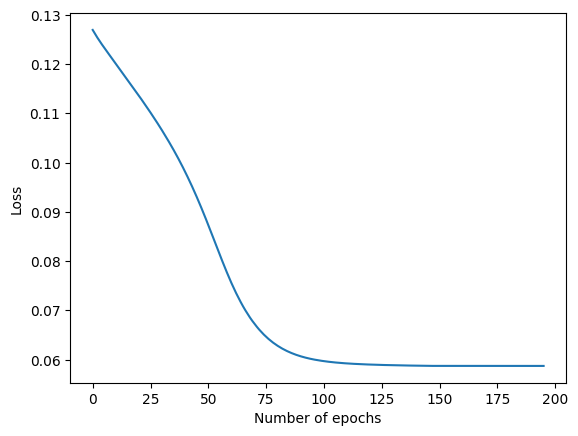

In [21]:
#hist = history.history['loss']
hist = pd.read_csv('ae_results/history.csv', sep='\t')
plt.plot(hist['epoch'],hist['loss'])
plt.xlabel('Number of epochs')
plt.ylabel('Loss')

Plot the learning rate history during training. The learning rate is reducced by a factor of 0.1 by default at every step.

Text(0, 0.5, 'learning rate')

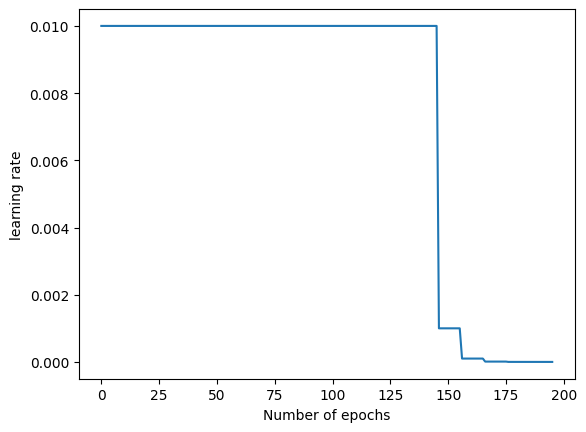

In [22]:
plt.plot(hist['epoch'],hist['lr'])
plt.xlabel('Number of epochs')
plt.ylabel('learning rate')

The projections of the input data in the latent dimension are store in the variable feat.

In [23]:
feat = ae.extract_features(X)
feat

40/40 [==============================] - 0s 5ms/step


array([[ 0.34207734, -0.06170468, -1.0558506 , ..., -0.85777986,
        -1.0601033 ,  0.38394442],
       [ 0.5304959 , -0.2520674 , -1.7665249 , ..., -1.4147824 ,
        -1.7684766 ,  0.7029386 ],
       [ 0.4096335 , -0.19419822, -1.5670576 , ..., -1.1526216 ,
        -1.4313495 ,  0.5674061 ],
       ...,
       [ 0.27801612, -0.08415003, -0.9230143 , ..., -0.7924627 ,
        -0.9388597 ,  0.34649497],
       [ 0.38027897, -0.05388028, -1.2139767 , ..., -1.0726482 ,
        -1.3023201 ,  0.5021538 ],
       [ 0.5901802 , -0.1464057 , -1.7338135 , ..., -1.4415871 ,
        -1.7785363 ,  0.68408793]], dtype=float32)

Apply k-Means and Agglomerative clustering on the latent space.

#### K-Means clustering in latent space

In [24]:
for i in np.arange(len(clinical_class_name)):
    if (i==0) or (clinical_class_number[i] != clinical_class_number[i-1]):
        clust = KMeans(n_clusters=clinical_class_number[i]).fit_predict(feat)

    name = clinical_class_name[i]
    c = Y[name]
    df = pd.DataFrame([c,clust])
    df = df.T
    df.columns = [0,1]
    df = df.dropna()
    
    print(name)
    print('Number of clusters: ', len(np.unique(clust)))
    print('Adjusted Mutual Information: ', ami(df[0],df[1]))
    print('Adjusted Rand Index: ', ars(df[0],df[1]))
    print('Fowlkes Mallows Score: ', fms(df[0],df[1]),'\n')

ER_STATUS
Number of clusters:  2
Adjusted Mutual Information:  -0.0009357994320135015
Adjusted Rand Index:  -0.000888628147658922
Fowlkes Mallows Score:  0.5688023721198295 

HER2_STATUS
Number of clusters:  2
Adjusted Mutual Information:  -0.00018056851874430143
Adjusted Rand Index:  -0.0010060531858909197
Fowlkes Mallows Score:  0.6259821875524978 

PR_STATUS
Number of clusters:  2
Adjusted Mutual Information:  -0.0005728269147835282
Adjusted Rand Index:  -0.0007229908967209043
Fowlkes Mallows Score:  0.5001204000261331 

ER_IHC
Number of clusters:  2
Adjusted Mutual Information:  0.0001431535956262535
Adjusted Rand Index:  -0.0005988203777574587
Fowlkes Mallows Score:  0.571267497693654 

HER2_SNP6
Number of clusters:  3
Adjusted Mutual Information:  -0.002285422307164777
Adjusted Rand Index:  -0.0015285658381996366
Fowlkes Mallows Score:  0.4483339002684586 

GRADE
Number of clusters:  3
Adjusted Mutual Information:  -0.0021075716398670117
Adjusted Rand Index:  -0.00218643412843065

#### Hierarchical clustering in latent space

In [25]:
for i in np.arange(len(clinical_class_name)):
    if (i==0) or (clinical_class_number[i] != clinical_class_number[i-1]):
        clust = AgglomerativeClustering(n_clusters=clinical_class_number[i]).fit_predict(feat)

    name = clinical_class_name[i]
    c = Y[name]
    df = pd.DataFrame([c,clust])
    df = df.T
    df.columns = [0,1]
    df = df.dropna()
    
    print(name)
    print('Number of clusters: ', len(np.unique(clust)))
    print('Adjusted Mutual Information: ', ami(df[0],df[1]))
    print('Adjusted Rand Index: ', ars(df[0],df[1]))
    print('Fowlkes Mallows Score: ', fms(df[0],df[1]),'\n')

ER_STATUS
Number of clusters:  2
Adjusted Mutual Information:  -0.0001873384058822444
Adjusted Rand Index:  0.009783515395733597
Fowlkes Mallows Score:  0.6091462200861281 

HER2_STATUS
Number of clusters:  2
Adjusted Mutual Information:  -0.0011303963075736689
Adjusted Rand Index:  -0.002594414880054425
Fowlkes Mallows Score:  0.6651751678217859 

PR_STATUS
Number of clusters:  2
Adjusted Mutual Information:  0.0009797244949386508
Adjusted Rand Index:  0.003050996087460528
Fowlkes Mallows Score:  0.5336289276689389 

ER_IHC
Number of clusters:  2
Adjusted Mutual Information:  -0.0007875835970794919
Adjusted Rand Index:  -0.00583414734881782
Fowlkes Mallows Score:  0.6046178652327019 

HER2_SNP6
Number of clusters:  3
Adjusted Mutual Information:  -0.0019342423262725752
Adjusted Rand Index:  -0.0021532657951889513
Fowlkes Mallows Score:  0.4402998984675947 

GRADE
Number of clusters:  3
Adjusted Mutual Information:  -0.00182894506752554
Adjusted Rand Index:  -0.0007420817486390971
Fowl

### 3.4 Conclusions <a class="anchor" id="1"></a>

None of the result obtained with the application of clustering methods on the reduced dimensional spaces are compatible with the considered true classifications. 

This may be due to several reasons:

1. Bad performance of dimensionality reduction algorithms that are not able to create a reliable latent space reflecting the structure of the input one. 
This outcome can be improved by changing dimensionality reduction methods or by tuning the algorithms with different parameters; 
in case of autoencoder, for example, different combinations of layers and number of nodes for each layer, different optimizers and loss metrics can be used. 

2. Bad performance of clustering methods that are not able to detect data patterns if applied in the latent space, even if it reflects the structure of the input one. 
Other input parameters and other clustering methods can be used for this step.

3. No correlation between genomic data and clinical data considered as true values. Both dimensionality reduction and clustering algorithms perform well but the the considered patterns are not found because they don't exist. 